### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc
import pandas as pd
import seaborn as sns

# Chargement des donnés

In [2]:
df = pd.read_csv("IHMexpertDATA.csv")

#Ajout d'une ligne qui defini le parametre
settings = pd.factorize(pd._libs.lib.fast_zip([df.n_trials.values, df.transition_duration.values,df.n_locks.values,df.lock_duration.values]))
test_id = pd.factorize(pd._libs.lib.fast_zip([df.user_ip.values, df.date.values]))
df['user_ip'] = pd.factorize(df.user_ip)[0] +1
df["settings_number"] = settings[0]
df["test_id"] = test_id[0]
nbtest = len(test_id[1])
columns = list(df.columns)
print("Nom des parametres :\n")
for i in range(len(columns)):
    print(f'{i} : {columns[i]}')
dfGroupedBySetting = df.groupby(df.settings_number)
settingLen = len(dfGroupedBySetting)

Nom des parametres :

0 : date
1 : user_ip
2 : trial_id
3 : block_id
4 : n_trials
5 : n_block
6 : block_size
7 : target_shape
8 : target_id
9 : target_freq
10 : target_n
11 : transition_duration
12 : n_locks
13 : lock_duration
14 : unlock_action
15 : lock_state
16 : occurence
17 : success
18 : time
19 : time_unlock
20 : slider_display_span
21 : n_opened_locker
22 : first_unlock_occurence
23 : first_unlock_trial
24 : last_unlock_occurence
25 : last_unlock_trial
26 : nb_total_click
27 : nb_useless_click
28 : exp_total_time
29 : settings_number
30 : test_id


In [3]:
print("Nombre de d'expérience : "+ str(nbtest))
print("Taile de la bd : "+ str(len(df)) + " exemples")

Nombre de d'expérience : 12
Taile de la bd : 912 exemples


In [4]:
print(f"---Apercu des {settingLen} settings dans la Dataframe---")
dconfig = df[df.columns[[29,11,12,13]]]
dconfig = dconfig.groupby(df.settings_number)
settingLen = len(dconfig)
dconfig.head(1)

---Apercu des 4 settings dans la Dataframe---


,settings_number,transition_duration,n_locks,lock_duration
0,0,12000,2,6000
76,1,12000,6,2000
152,2,12000,4,3000
304,3,12000,3,4000


In [5]:
def getExperience(df,n):
    return df.loc[df["test_id"] == n ]

In [6]:
set1 = getExperience(df,0)
set1 = set1[df.columns[[30,29,2,3,4,5,6,7,8,9,10,14,15,16]]]
shape = list(np.unique(set1["target_shape"]))
shapeList = []
for i in shape:
    shapeList.append(set1.loc[set1["target_shape"] == i])
shapeList[0].head()
allconfig = []
for i in range(len(shape)):
    allconfig.append(shapeList[i][shapeList[i].columns[[4,5,6,7,8,9,10]]].iloc[0])
allconfig = pd.DataFrame(allconfig)
allconfig[["n_block","target_shape","target_freq","target_n"]]

,n_block,target_shape,target_freq,target_n
0,4,Circle,4,5
5,4,Cross,8,5
1,4,Square,5,5
3,4,Triangle,2,5


In [7]:
total_trial = df["n_trials"].iloc[0]
total_block = df["n_block"].iloc[0]
total_BlockSize = df["block_size"].iloc[0]
print(f"L'experience fait {total_block} block de taille {total_BlockSize} soit {total_trial} essais")
freq = allconfig["target_freq"].sort_values().tolist()
print(f"Les frequences sont {freq}")

L'experience fait 4 block de taille 19 soit 76 essais
Les frequences sont [2, 4, 5, 8]


# Fonctions Utiles

In [8]:
def printStats(X):
    print(f'Mean : {np.mean(X)}, Min : {np.min(X)}, Max : {np.max(X)}, Std : {np.std(X)}')


In [9]:
def plot(X,Y,legendX, legendY):
    ax = plt.subplot(1,1,1)
    ax.set_title(f'{legendX} vs {legendY}')
    ax.scatter(x=X,y=Y,label='Data')
    plt.plot(X, Y,color='red',label='Fitting Line')
    ax.set_xlabel(legendX)
    ax.set_ylabel(legendY)
    ax.legend(loc='best')
    plt.show()
    

In [10]:
def normalFromTimes(times,mode = None):
    ax = plt.subplot(1,1,1)
    if type(times) == list:
        for i in range(len(times)):
            sigma = np.std(times[i])
            mu = np.mean(times[i])
            Y = sc.norm(mu,sigma)
            X = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            ax.scatter(x=X,y=Y.pdf(X),label=f'Data {mode[i]}')
            plt.plot(X, Y.pdf(X),color='red')
            ax.set_title(f'Repartition du temps')
    else:
        sigma = np.std(times)
        mu = np.mean(times)
        Y = sc.norm(mu,sigma)
        X = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax.scatter(x=X,y=Y.pdf(X),label='Data')
        plt.plot(X, Y.pdf(X),color='red',label='Fitting Line')
        if mode:
            ax.set_title(f'Repartition du temps en mode {mode}')
    ax.set_xlabel('Temps (en ms)')
    ax.legend(loc='best')
    plt.show()
    

In [11]:
def timeToMode(dtime):
    mode=[]
    setting = []
    for i in dtime.index: 
        for j in range(settingLen):
                if dtime["settings_number"][i] == j:
                    setting.append(f'{dtime["n_locks"][i]} lock * {dtime["lock_duration"][i]/1000} s')
        if dtime["n_locks"][i] == dtime["lock_state"][i]:
            mode.append("Expert")
        elif dtime["unlock_action"][i] == 1:
            mode.append("Unlock")
        else:
            mode.append("Novice")
    copy = dtime.copy()
    copy["Mode"] = mode
    copy["Setting"] = setting
    return copy

# Visualisation

## Courbe génerale du temps au cours d'une experience entiere

In [12]:
dtime = df
dtime = timeToMode(dtime)


In [13]:
def showTrialbyId(dtime, Id):
    id_exp = dtime.loc[dtime["test_id"] == Id ]
    sns.relplot(data = id_exp,x="trial_id",y="time",hue="Mode",s=100)
    plt.plot(id_exp["trial_id"],id_exp["time"])
    plt.title("plot of the id "+str(Id))
    
def showTrialbySettings(dtime,n):
    grp4 = dtime.loc[dtime["settings_number"] == n]
    sns.relplot(data = grp4,x="trial_id",y="time",hue="Mode",s=100)
    plt.plot(grp4["trial_id"],grp4["time"])
    plt.title("plot of the setting "+str(n))
    
def showTrialbyUser(dtime, user_id):
    user1 = dtime.loc[dtime["user_ip"] == user_id]
    sns.relplot(data = user1,x="trial_id",y="time",hue="Mode",s=100)
    plt.plot(user1["trial_id"],user1["time"])
    plt.title("plot of the user "+str(user_id))

In [14]:
#Choix par settings
#showTrialbySettings(dtime,3)

In [15]:
#Choix par utilisateur
#showTrialbyUser(dtime,1)

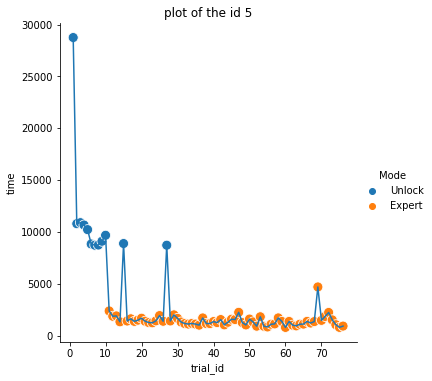

In [16]:
#choix par id de l'experience
showTrialbyId(dtime,5)

## Graphes de Gauss des differents modes

In [17]:
dtimeExpertMode = dtime.loc[dtime["n_locks"] == dtime["lock_state"]].copy()
dtimeExpertMode['Mode'] = "Expert"

dtimeUnlock = dtime.loc[dtime["unlock_action"] == 1].copy()
dtimeUnlock['Mode'] = "Unlock"

dtimeNovice = dtime.drop(dtimeExpertMode.index).copy()
dtimeNovice = dtimeNovice.drop(dtimeUnlock.index)
dtimeNovice = dtimeNovice.drop(dtimeNovice.loc[dtimeNovice['time']>10000].index) #drop values >10s

dtimeNovice['Mode'] = "Novice"

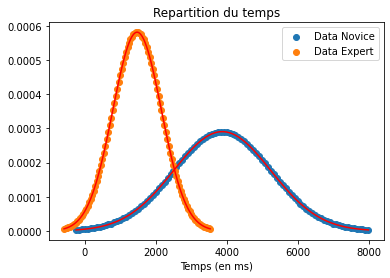

Mode Novice : 
Mean : 3870.0150375939847, Min : 2368, Max : 8620, Std : 1372.467669394536
Mode Expert : 
Mean : 1473.6048387096773, Min : 627, Max : 10177, Std : 685.9547433880656


In [18]:
normalFromTimes([dtimeNovice.time,dtimeExpertMode.time],["Novice",'Expert'])
print("Mode Novice : ")
meanNovice = np.mean(dtimeNovice.time)
printStats(dtimeNovice.time)
print("Mode Expert : ")
meanExpert = np.mean(dtimeExpertMode.time)
printStats(dtimeExpertMode.time)

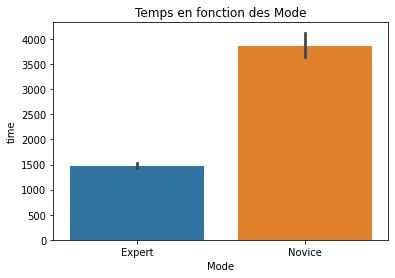

In [19]:
dr = pd.concat([dtimeExpertMode,dtimeNovice])
ax3 = sns.barplot(y = "time",x = "Mode", data = dr)
plt.title("Temps en fonction des Mode")
plt.show()


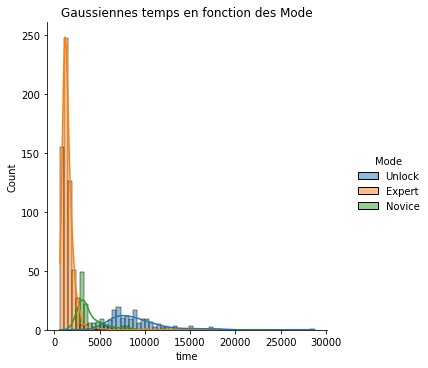

In [20]:
ax2 = sns.displot(x = "time", hue = "Mode",kde = True, data = dtime)
plt.title("Gaussiennes temps en fonction des Mode")
plt.show()

In [21]:
unlock = dtime[~dtime["Mode"].isin(["Novice","Expert"])].copy()
unlock["slideTime"] = unlock["time"]-unlock["time_unlock"]
#ax3 = sns.displot(x = "slideTime", hue = "Mode",kind = "kde", data = unlock)

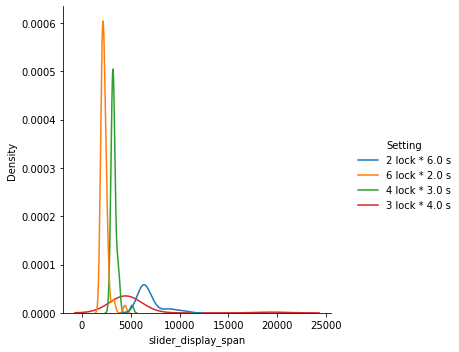

In [22]:
ax4 = sns.displot(x = "slider_display_span", hue = "Setting",kind = "kde", data = unlock)

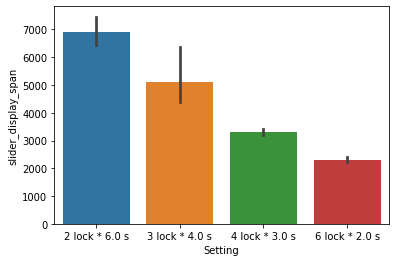

In [23]:
ax4 = sns.barplot(y = "slider_display_span", x = "Setting", data = unlock, order = ["2 lock * 6.0 s","3 lock * 4.0 s","4 lock * 3.0 s","6 lock * 2.0 s"])

In [24]:
unlock_grp = unlock.groupby(["Setting"])
means_unlock = {}
for id,grp in unlock_grp:
    #filtre les essais avec 1 seconde de plus que prévu
    print(f"Moyenne pour {grp['Setting'].iloc[0]}")
    print(grp[grp["slider_display_span"]<grp["lock_duration"]+1000]["slider_display_span"].mean())
    means_unlock[grp['Setting'].iloc[0]] = grp[grp["slider_display_span"]<grp["lock_duration"]+1000]["slider_display_span"].mean()


Moyenne pour 2 lock * 6.0 s
6286.571428571428
Moyenne pour 3 lock * 4.0 s
4410.047619047619
Moyenne pour 4 lock * 3.0 s
3262.468085106383
Moyenne pour 6 lock * 2.0 s
2233.1746031746034


## Courbe théorique

In [29]:
def MakeTheo():
    theorique = {"Setting":[],"frequence":[],"Mode" : [], "temps": []}
    mode = ["novice","expert"]
    means_unlock = {"6 lock * 2.0 s":(6,2233.1),"4 lock * 3.0 s":(4,3262),"3 lock * 4.0 s":(3,4410.0),"2 lock * 6.0 s":(2,6286.5)}
    freq = [8,5,4,2]
    for sett in means_unlock:
        for m in mode:
            nblock,timelock = means_unlock[sett]
            for f in freq:
                theorique["Setting"].append(sett)
                theorique["Mode"].append(m)
                theorique["frequence"].append(f)

                if m == "novice" : 
                    theorique["temps"].append(np.ceil(meanNovice))
                else:
                    if f*total_block >= nblock:
                        expertTime = ((meanNovice + timelock)*nblock + (f*total_block-nblock)*meanExpert)
                    else:
                        expertTime = ((meanNovice + timelock)*(f*total_block))
                    theorique["temps"].append(np.ceil(expertTime/(f*total_block)))
    return pd.DataFrame(theorique)
theo = MakeTheo()

In [30]:
print(dtime["Setting"].unique())
print(dtime["lock_duration"].unique())
print(dtime["n_locks"].unique())

['2 lock * 6.0 s' '6 lock * 2.0 s' '4 lock * 3.0 s' '3 lock * 4.0 s']
[6000 2000 3000 4000]
[2 6 4 3]


In [31]:
user = {"Setting":[],"frequence":[],"Mode" : [], "temps": []}
means_unlock = means_unlock = {"6 lock * 2.0 s":(6,2233.1),"4 lock * 3.0 s":(4,3262),"3 lock * 4.0 s":(3,4410.0),"2 lock * 6.0 s":(2,6286.5)}
freq = [8,5,4,2]
for sett in means_unlock:
    for f in freq:
        user["Setting"].append(sett)
        user["Mode"].append("User")
        user["frequence"].append(f)
        userTime = dtime.loc[(dtime["target_freq"] == f)&(dtime["Setting"] == sett)]["time"].mean()
        user["temps"].append(userTime)
user = pd.DataFrame(user)
res = pd.concat([theo,user])

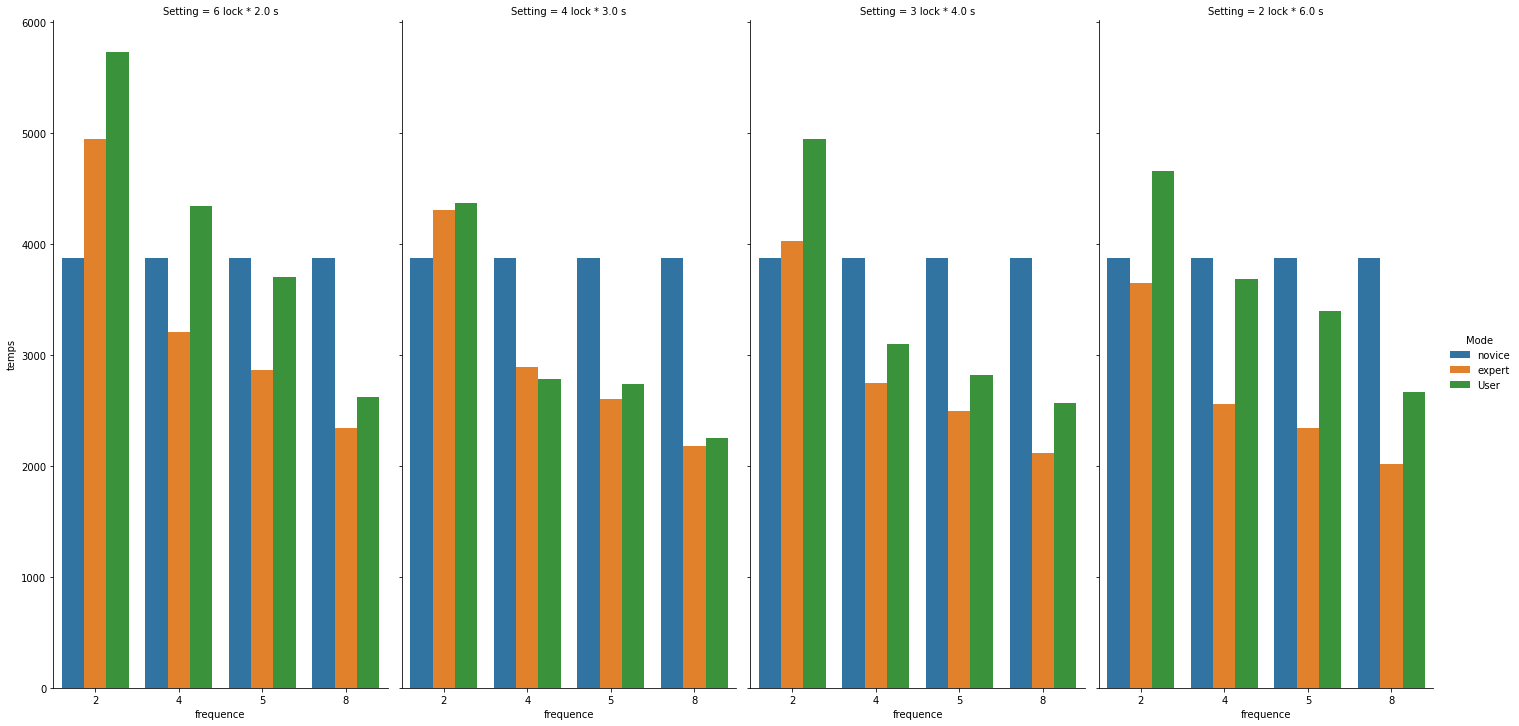

In [32]:
sns.catplot(data =res, x = "frequence", y ="temps",hue = "Mode",col = "Setting",kind = "bar",height=10,aspect=0.5)


<AxesSubplot:xlabel='frequence', ylabel='temps'>

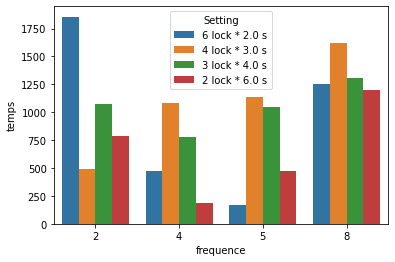

In [119]:
diff = {"Setting":[],"frequence":[],"temps": []}
for f in freq:
    for sett in means_unlock:
        curr = res.loc[(res["frequence"]==f)&(res["Setting"]==sett)]
        novice = curr.loc[curr["Mode"] == "novice"]["temps"].reset_index(drop=True)
        user = curr.loc[curr["Mode"] == "User"]["temps"].reset_index(drop=True)
        diff["Setting"].append(sett)
        diff["frequence"].append(f)
        diff["temps"].append(np.abs(novice-user).loc[0])
diff = pd.DataFrame(diff)
sns.barplot(data = diff,x = "frequence",y="temps",hue="Setting")

## All config

In [29]:
#sns.kdeplot(data=a, x="n_opened_locker",hue="Setting")

In [30]:
#sns.barplot(data= a, y="n_opened_locker",x="Setting")

In [31]:
#sns.kdeplot(data=a, x="first_unlock_occurence",hue="Setting")

In [32]:
#sns.kdeplot(data=a, x="last_unlock_occurence",hue="Setting")

## By form

In [33]:
tests = [timeToMode(getExperience(df,i)) for i in range(nbtest)]
#b = []
#for test in tests:
#    c = test[test["unlock_action"]== 1]["target_shape"].value_counts()
#    c.name = None
#    print(test["Setting"].iloc[0])

#    b.append((c, test[test["unlock_action"]== 1]["Setting"]))

In [34]:
#d = {}
#for cpt,setting in b:
#    if setting not in d:
#        d[setting] = pd.DataFrame(cpt)
#    else: 
#        d[setting] = pd.concat([d[setting],cpt], axis = 1).fillna(0)

#for e in d:
#    d[e] = d[e].transpose()

In [35]:
#for e in d: 
#    sns.displot(kind = "kde", data = d[e])
#    plt.title(f"Repartition des unlock dans le mode " + e)
#    plt.xlabel("nombre d'unlock")

In [36]:
#for e in d:
#    print(pd.DataFrame(d[e]))

## By freq

In [37]:
dp = df[df.columns[[30,29,1,2,7,9,12,13,14,15,18,19,20,21]]]
dp = timeToMode(dp)
unlocked = dp

In [38]:
b = pd.DataFrame(unlocked.groupby(["test_id","Setting","target_freq"],group_keys=False)[["lock_state"]].max())
b["lock_state"]+=1
b.reset_index(inplace = True)

## nombre de deverouillage en fonction de la frequence d'apparition pour chaque mode

<AxesSubplot:xlabel='target_freq', ylabel='lock_state'>

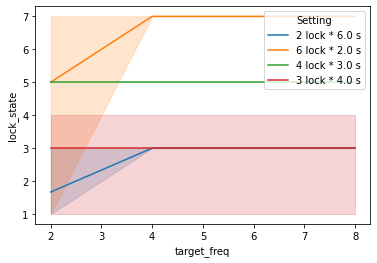

In [39]:
sns.lineplot(data = b, x = "target_freq", y="lock_state",hue="Setting")

In [40]:
def addset(row):
    return f'{row["n_locks"]} lock * {row["lock_duration"]/1000} s'

In [41]:
dg = dp.copy()
dg["setting"] = dg.apply(lambda row:addset(row),axis = 1)
dgroup = dg.groupby(["test_id"])

In [42]:
d = {"epreuve":[], "setting":[], "nbnovice":[], "nbexpert":[]}
for no,group in dgroup:
    d["epreuve"].append(no)
    d["setting"].append(group.iloc[0]["setting"])
    d["nbnovice"].append(group[group["Mode"]=="Novice"].count(numeric_only=True)[0] )
    d["nbexpert"].append(group[group["Mode"]=="Expert"].count(numeric_only=True)[0])
dg = pd.DataFrame(d)

## Nb de d'utilisation du mode novice selon les config

<AxesSubplot:xlabel='setting', ylabel='nbnovice'>

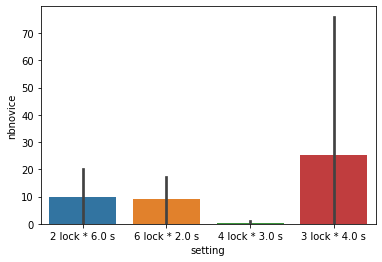

In [43]:
sns.barplot(data= dg,x = "setting",y="nbnovice")

## Nb de d'utilisation du mode expert selon les config

<AxesSubplot:xlabel='setting', ylabel='nbexpert'>

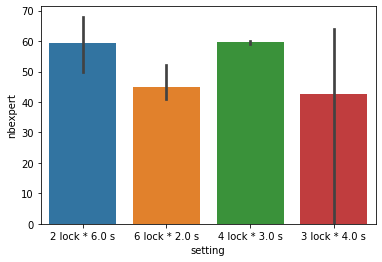

In [44]:
sns.barplot(data= dg,x = "setting",y="nbexpert")

In [20]:
nblock = [1,2,3,4,5,6]
freq = [8,6,4,1]
Bloc = 4
Total = 76
noviceTime = 4.2
expertTime = 1.8
tempsLearning = 30
tempSlider = [tempsLearning/lock-noviceTime for lock in nblock]


In [22]:
theo = {"nblock":[],"frequence":[],"Mode" : [], "temps": []}
for lock in range(len(nblock)):
    for f in freq:
        for m in ["novice","expert"]:
            theo["nblock"].append(lock)
            theo["frequence"].append(f)
            if m == "novice" : 
                theo["temps"].append(noviceTime)
                theo["Mode"].append("Novice")
            else:
                if f*Bloc >= nblock[lock]:
                    a = ((noviceTime + tempSlider[lock])*nblock[lock] + (f*Bloc-nblock[lock])*expertTime)
                else:
                    a = ((noviceTime + tempSlider[lock])*(f*Bloc))
                theo["Mode"].append("Expert")
                theo["temps"].append(a/(f*Bloc))

theo = pd.DataFrame(theo)


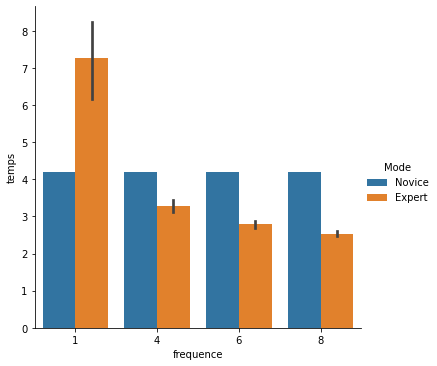

In [28]:
sns.catplot(data =theo, x = "frequence", y ="temps",hue = "Mode",kind = "bar",height=5,aspect=1)